This codes take a few genes, calculate their summed expression (could be weighted), and then calculate the survival curve based on TCGA samples.   

In [293]:
#Interested genes
genelist = ['CCR5']
#The fraction of patients classified as high exp and low exp 
high_thre = 0.5
low_thre  = 0.5

In [294]:
#load package
import pandas as pd
import json
import gzip
import glob
import mygene
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import lifelines as ll

In [295]:
#load clinical info for some TCGA-LUAD data
#clinical data from GDC
clinical = pd.read_csv('LUAD_clinical.tsv',sep='\t')

In [296]:
clinical

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,8c695c24-e7f9-449a-9258-a1bc8a33bf9a,TCGA-97-8174,TCGA-LUAD,67,'--,'--,'--,'--,-24725,164,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
1,8c695c24-e7f9-449a-9258-a1bc8a33bf9a,TCGA-97-8174,TCGA-LUAD,67,'--,'--,'--,'--,-24725,164,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
2,86dac334-f30e-438e-810a-8e45f69dbb7e,TCGA-MP-A4TF,TCGA-LUAD,58,'--,'--,'--,'--,-21387,336,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
3,86dac334-f30e-438e-810a-8e45f69dbb7e,TCGA-MP-A4TF,TCGA-LUAD,58,'--,'--,'--,'--,-21387,336,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Radiation Therapy, NOS"
4,532c1852-76dd-489f-9380-36766d6e3c34,TCGA-86-7714,TCGA-LUAD,61,'--,'--,'--,'--,-22619,625,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,7fd03220-531e-4ef8-beca-e9703e8c0ae1,TCGA-NJ-A4YG,TCGA-LUAD,65,'--,'--,'--,'--,-23812,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
1026,6ee9caec-65ac-46db-9426-ffaa31967ae2,TCGA-95-8494,TCGA-LUAD,67,'--,'--,'--,'--,-24773,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
1027,6ee9caec-65ac-46db-9426-ffaa31967ae2,TCGA-95-8494,TCGA-LUAD,67,'--,'--,'--,'--,-24773,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
1028,99c35245-e1c8-4805-b7a5-f703bb506030,TCGA-MP-A4TC,TCGA-LUAD,77,'--,'--,'--,'--,-28471,74,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"


In [297]:
#load the metadata that link patient id with their RNAseq data
#metadata from GDC
jfile = open('LUAD.json')
metadata = json.load(jfile)
jfile.close()

In [298]:
#Then we transform gene name into ENSG index
mg = mygene.MyGeneInfo()
ensglist = mg.querymany(genelist, scopes='symbol',species='human',fields='ensembl.gene')
ensglist = [x['ensembl'] for x in ensglist]
#one gene name may have many ensg
print(ensglist)

querying 1-1...done.
Finished.
[{'gene': 'ENSG00000160791'}]


In [299]:
#so, get all patient id with a survival data
ptidlist = []
for index in range(len(metadata)):
    ptid = metadata[index]['associated_entities'][0]['entity_submitter_id']
    ptid = '-'.join(ptid.rsplit('-')[:3])
    ptidlist.append(ptid)
print(ptid)

#file name is 
filelist = []
for index in range(len(metadata)):
    filename = metadata[index]['file_name']
    filelist.append(filename)
print(filename)

TCGA-55-8619
d123efcb-e79f-4ac5-a0a2-068634e84d26.FPKM.txt.gz


In [300]:
#patient survival time is in this list
survlist = []; statelist = []
for ptid in ptidlist:
    survd = list(clinical['days_to_death'][clinical['case_submitter_id']==ptid])[0]
    if survd.isdigit():
        survd = float(survd)
        state = 1
    else:
        state = 0
        diagy = list(clinical['year_of_diagnosis'][clinical['case_submitter_id']==ptid])[0]
        followd = list(clinical['days_to_last_follow_up'][clinical['case_submitter_id']==ptid])[0]
        if diagy.isdigit() and followd.isdigit(): 
            survd = (2020-int(diagy)+1)*365-int(followd)
        else:
            survd = 'NA'
    survlist.append(survd)
    statelist.append(state)

In [301]:
#expression list
explist = []
for filename in filelist:
    infiles = sorted(glob.glob('gdc_download_20201103_050948.838102/*/'+filename))
    expdict = {}
    with gzip.open(infiles[0], 'rb') as f:
        for line in f:
            line = line.decode().rstrip().rsplit('\t')
            expdict[line[0]] = float(line[1])
    ptexp = []
    for records in ensglist:
        ptexp.append(0)
    for transcript in expdict:
        for i,records in enumerate(ensglist):
            for record in records:
                if record == 'gene':
                    ensg = records['gene']
                else:
                    ensg = record['gene']
                if ensg in transcript:
                    exp = expdict[transcript]
                    ptexp[i] += exp
    explist.append(ptexp)

In [302]:
#adjust expression value to weighted sum
#assuming equal function 
sumlist = []
for records in ensglist:
    sumlist.append(0)
for ptexp in explist:
    for i,exp in enumerate(ptexp):
        sumlist[i] += exp
adjexplist = []
for ptexp in explist:
    adjexp = 0
    for i,exp in enumerate(ptexp):
        adjexp += exp/(sumlist[i]/len(explist))
    adjexplist.append(adjexp)

In [303]:
lowexp = np.quantile(adjexplist,low_thre)
highexp = np.quantile(adjexplist,high_thre)
grouplist = []
for i in range(len(adjexplist)):
    if adjexplist[i]<lowexp: 
        grouplist.append('low_exp')
    elif adjexplist[i]>highexp: 
        grouplist.append('high_exp')
    else:
        grouplist.append('NA')

In [304]:
df = pd.DataFrame(list(zip(survlist, statelist,grouplist)), 
               columns =['survival','state','group']) 

In [305]:
#filter NA data
alldata = df[df['survival']!='NA']
lowdata = alldata[alldata['group']=='low_exp']
highdata = alldata[alldata['group']=='high_exp']
#1 is dead, #0 is alive

/Users/tianhao/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/tianhao/anaconda3/lib/python3.7/site-packages/lifelines/utils/__init__.py:1173: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


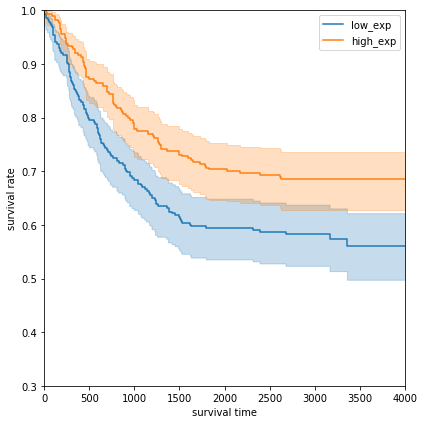

In [306]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
kmf = ll.KaplanMeierFitter()
kmf.fit(lowdata['survival'], event_observed=lowdata['state'],label='low_exp') 
ax = kmf.plot()
kmf.fit(highdata['survival'], event_observed=highdata['state'],label='high_exp') 
ax = kmf.plot(ax=ax)
ax.set_xlim(0,4000)
ax.set_ylim(0.3,1)
ax.set_ylabel('survival rate')
ax.set_xlabel('survival time')
plt.tight_layout()
plt.savefig('CCR5_LUAD_50vs50.png',dpi=600)

In [309]:
results = ll.statistics.logrank_test(lowdata['survival'], highdata['survival'], lowdata['state'], highdata['state'], alpha=.99)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.45 <0.005      8.10

In [308]:
results

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.45 <0.005      8.10